# Layout

All UBC ubcpdk.components cells are conveniently combined into the ubcpdk.components module.

In [ ]:
import gdsfactory as gf

from ubcpdk import PDK, cells

PDK.activate()

gplugins[sax] not installed, no simulation models available.


2025-09-06 13:48:29.210 | INFO     | kfactory.kcell:show:3989 - klive v0.3.3: Opened file '/Users/j/c/pdks/ubc/build/gds/215281679.oas'
2025-09-06 13:48:35.356 | INFO     | kfactory.kcell:show:3989 - klive v0.3.3: Opened file '/Users/j/c/pdks/ubc/build/gds/3940425681.oas'
2025-09-06 13:48:38.033 | ERROR    | kfactory.kcell:name:659 - Name conflict in kfactory.kcell::name at line 659
Renaming Unnamed_349 (cell_index=349) to straight_L10_CSstrip_WNone_N2_with_gc would cause it to be named the same as:
 - straight_L10_CSstrip_WNone_N2_with_gc (cell_index=130), function_name=None, basename=None
2025-09-06 13:48:38.048 | ERROR    | kfactory.kcell:name:659 - Name conflict in kfactory.kcell::name at line 659
Renaming Unnamed_351 (cell_index=351) to straight_L10_CSstrip_WNone_N2_with_gc would cause it to be named the same as:
 - straight_L10_CSstrip_WNone_N2_with_gc (cell_index=349), function_name=None, basename=None
 - straight_L10_CSstrip_WNone_N2_with_gc (cell_index=130), function_name=None

## Fixed Component cells

Most `ubcpdk` components are imported from GDS files as fixed cells.

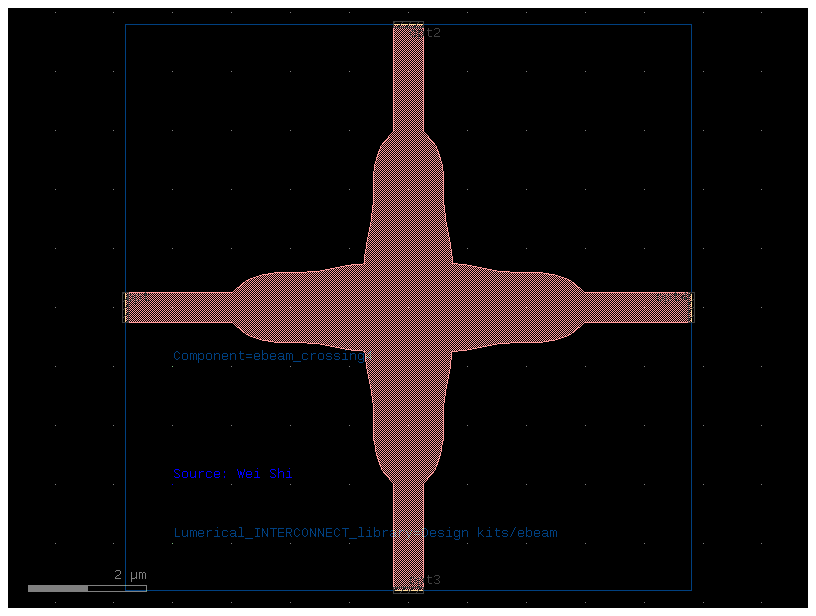

In [2]:
c = cells.ebeam_crossing4()
c.plot()

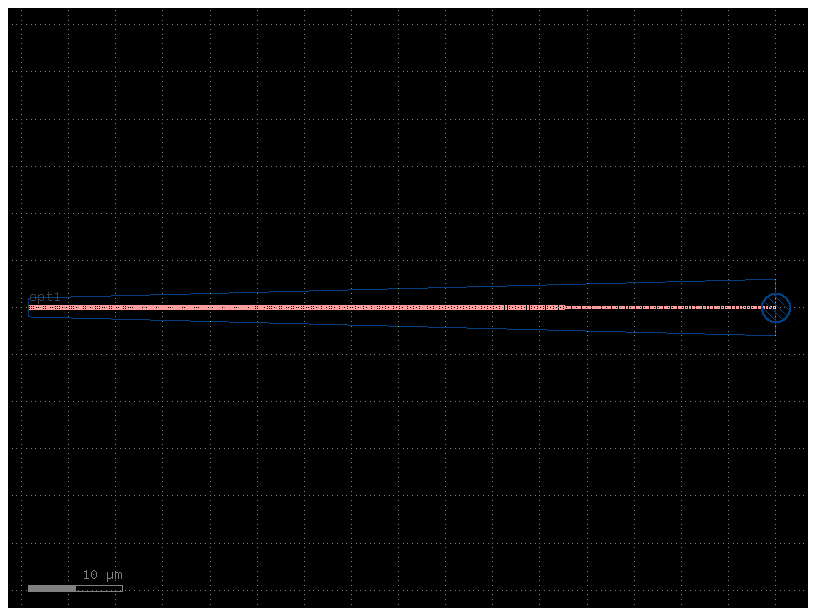

In [3]:
c = cells.ebeam_swg_edgecoupler()
c.plot()

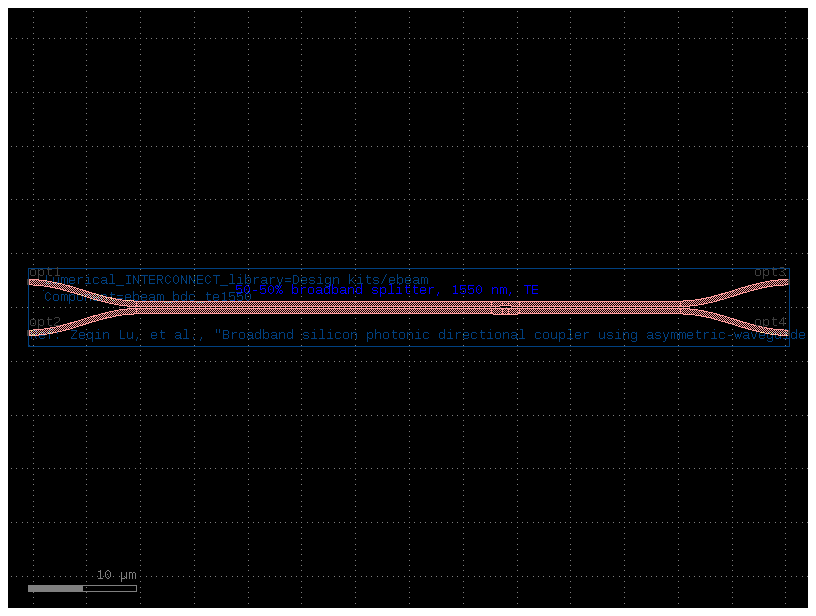

In [4]:
c = cells.ebeam_bdc_te1550()
c.plot()

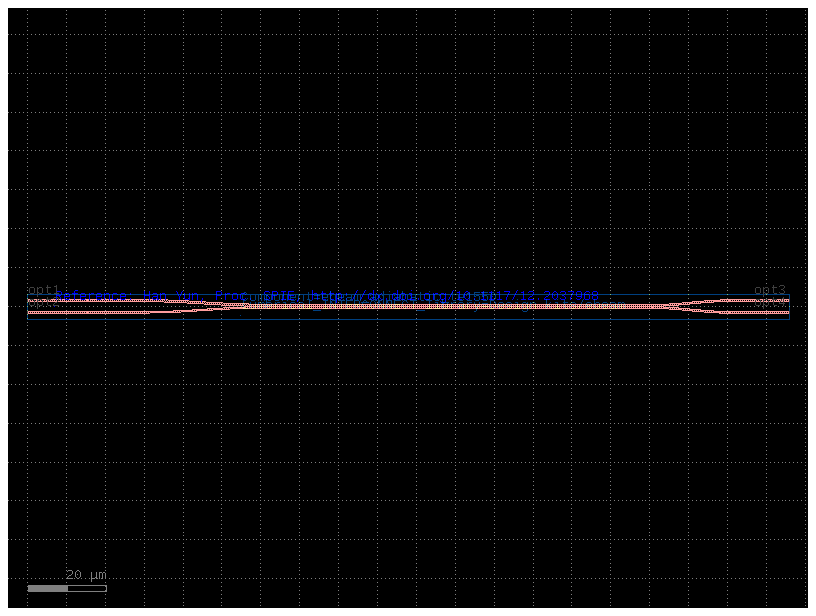

In [5]:
c = cells.ebeam_adiabatic_te1550()
c.plot()

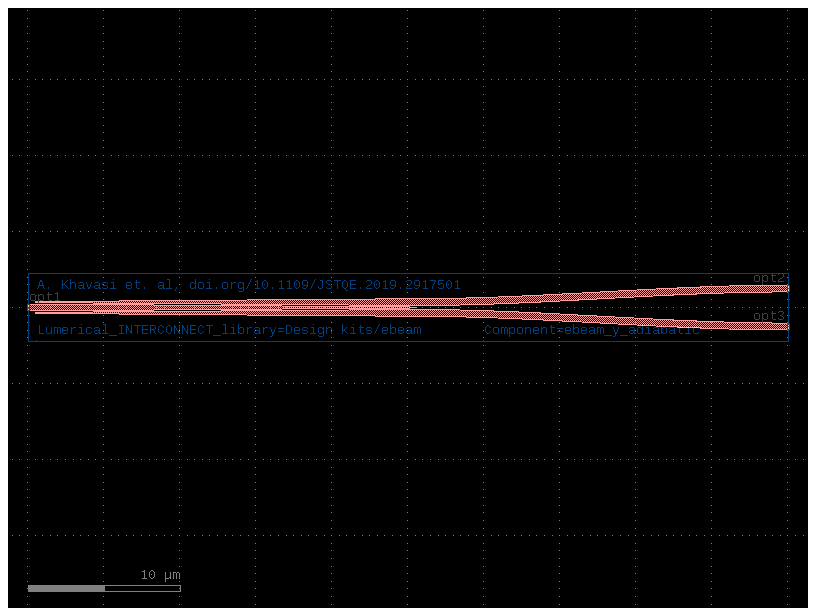

In [6]:
c = cells.ebeam_y_adiabatic()
c.plot()

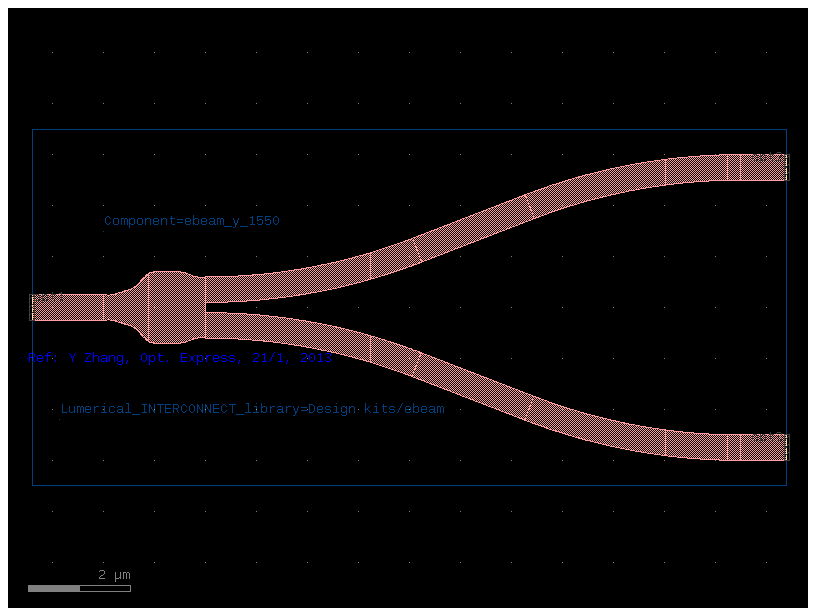

In [7]:
c = cells.ebeam_y_1550()
c.plot()

## Parametric Component PCells

You can also define cells adapted from gdsfactory generic pdk.

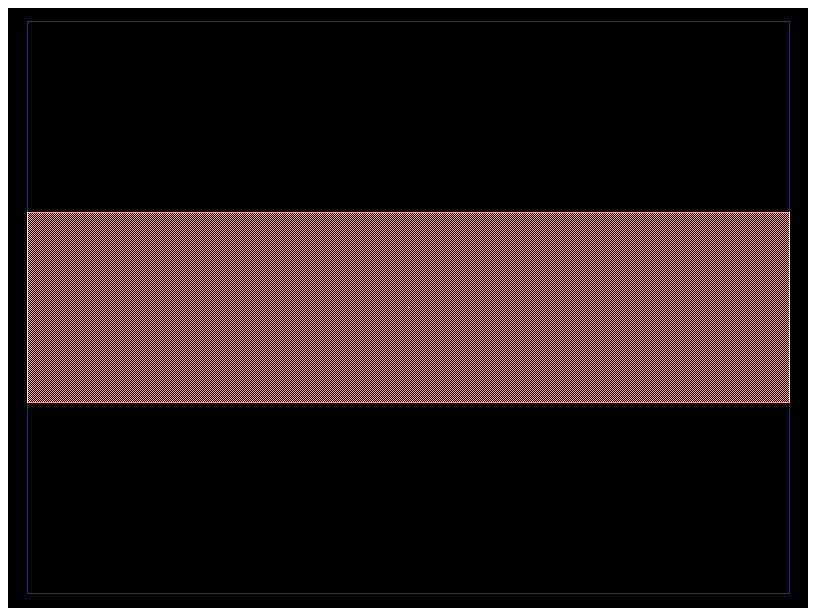

In [8]:
c = cells.straight(length=2)
c.plot()

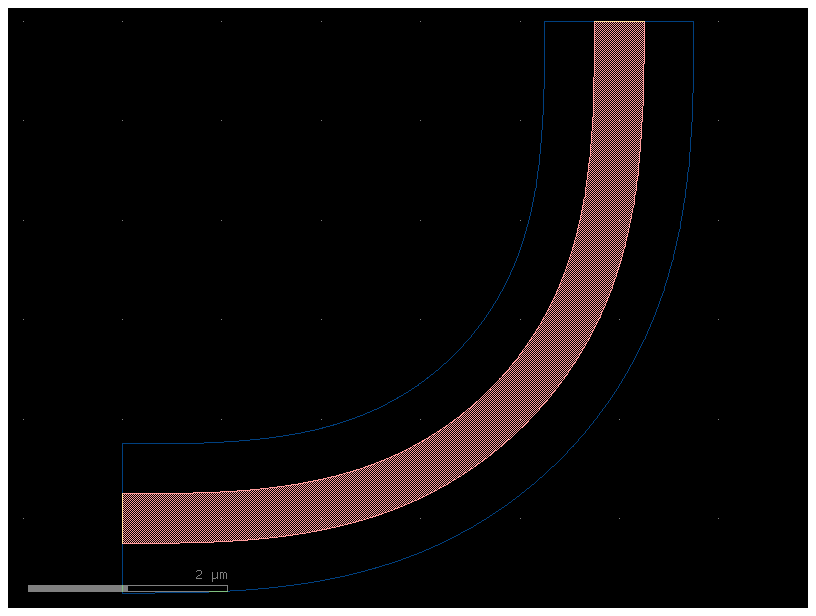

In [9]:
c = cells.bend_euler(radius=5)
c.plot()

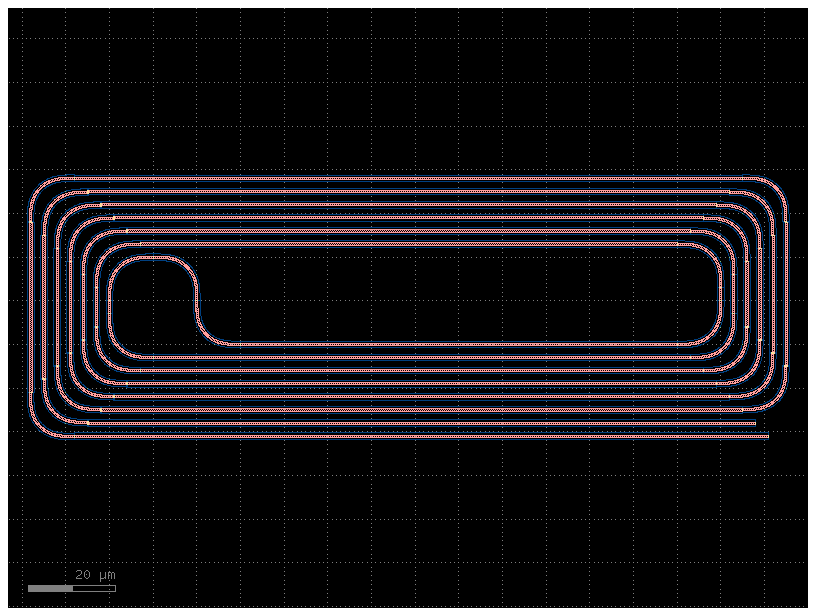

In [10]:
c = cells.spiral()
c.plot()

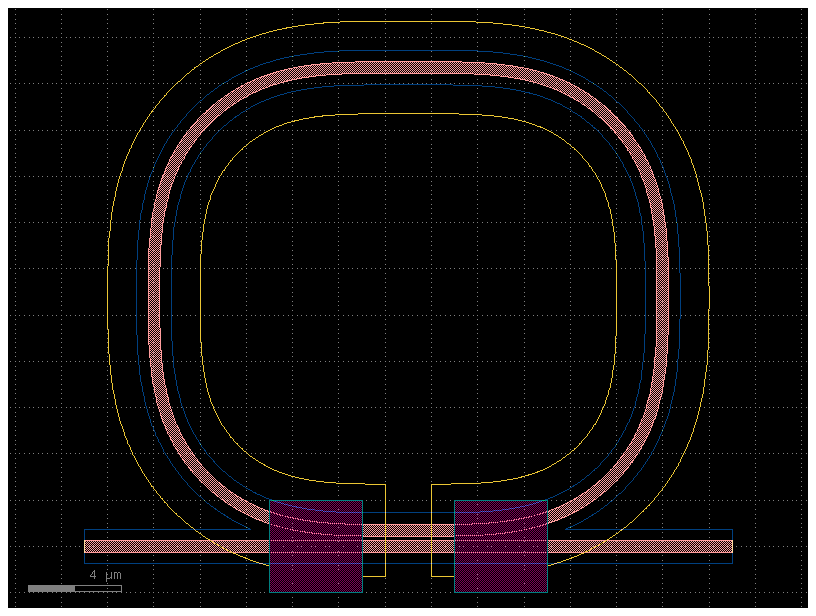

In [11]:
c = cells.ring_single_heater()
c.plot()

## Components with grating couplers

To test your devices you can add grating couplers. Both for single fibers and for fiber arrays.

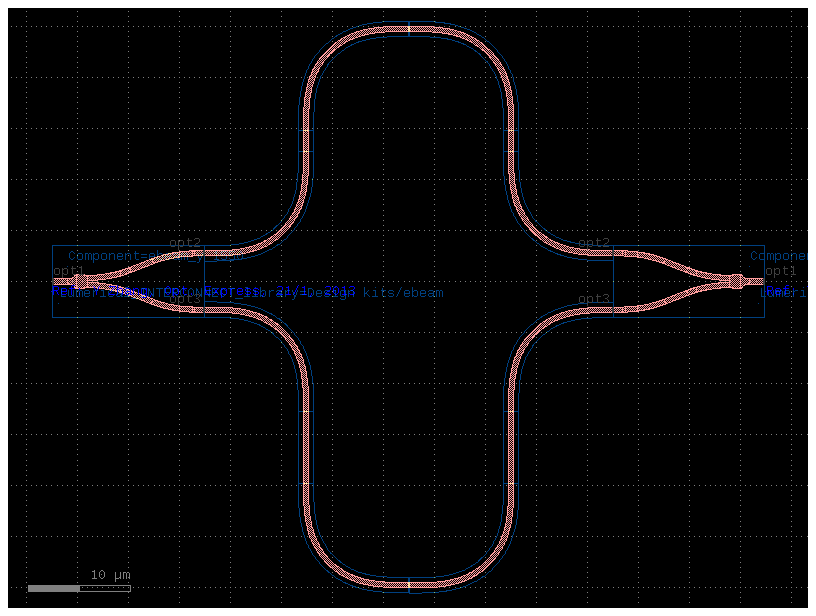

In [12]:
splitter = cells.ebeam_y_1550()
mzi = gf.components.mzi(splitter=splitter)
mzi.plot()

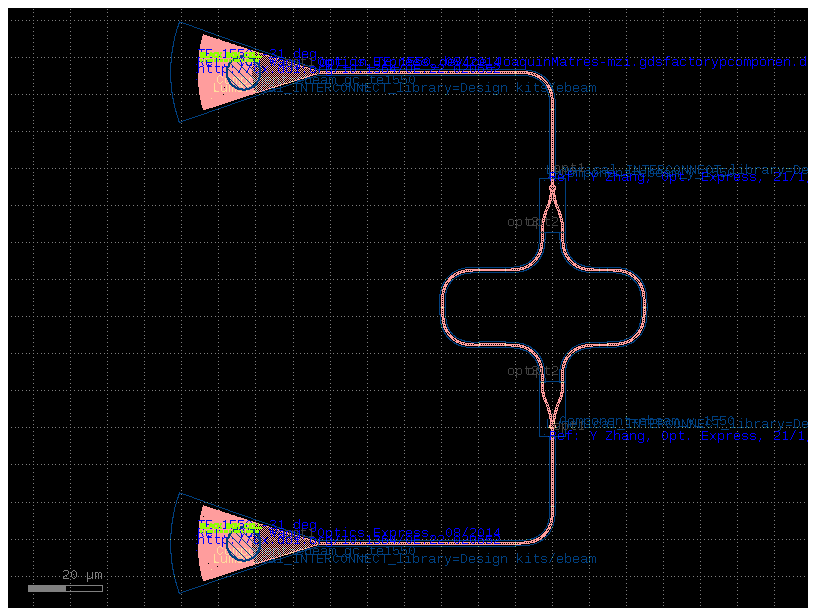

In [13]:
component_fiber_array = cells.add_fiber_array(component=mzi, fanout_length=5)
component_fiber_array.plot()

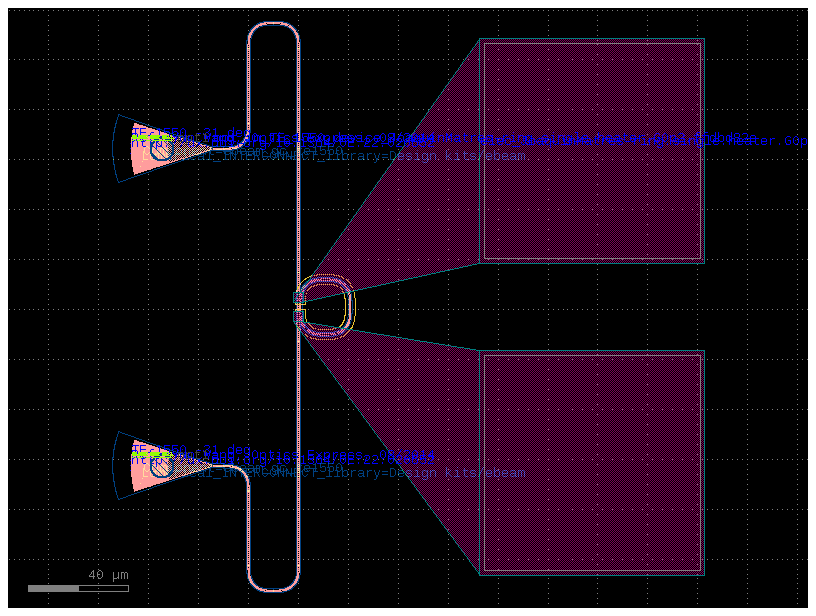

In [14]:
c = cells.ring_single_heater()
c = cells.add_fiber_array_pads_rf(c)
c.plot()

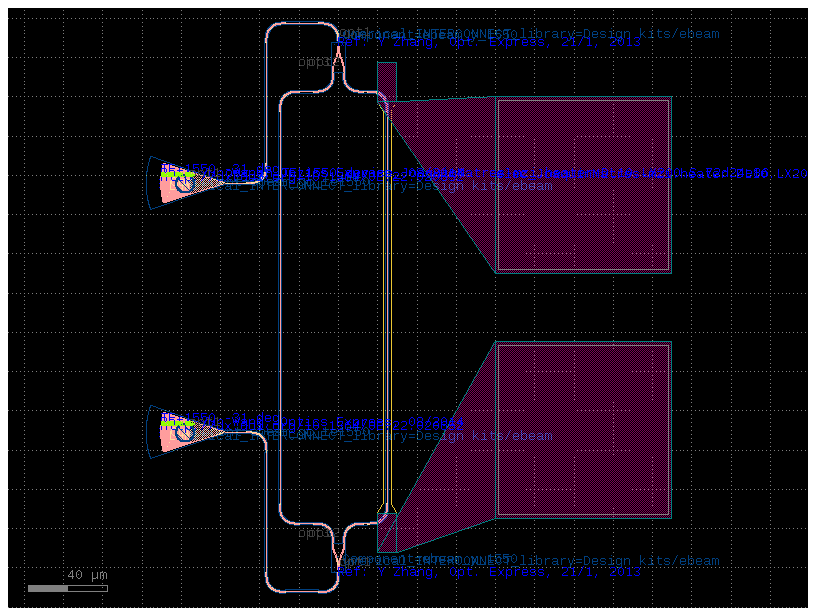

In [15]:
c = cells.mzi_heater()
c = cells.add_fiber_array_pads_rf(c)
c.plot()

## 3D rendering

In [16]:
scene = c.to_3d()
scene.show()

## Die assembly

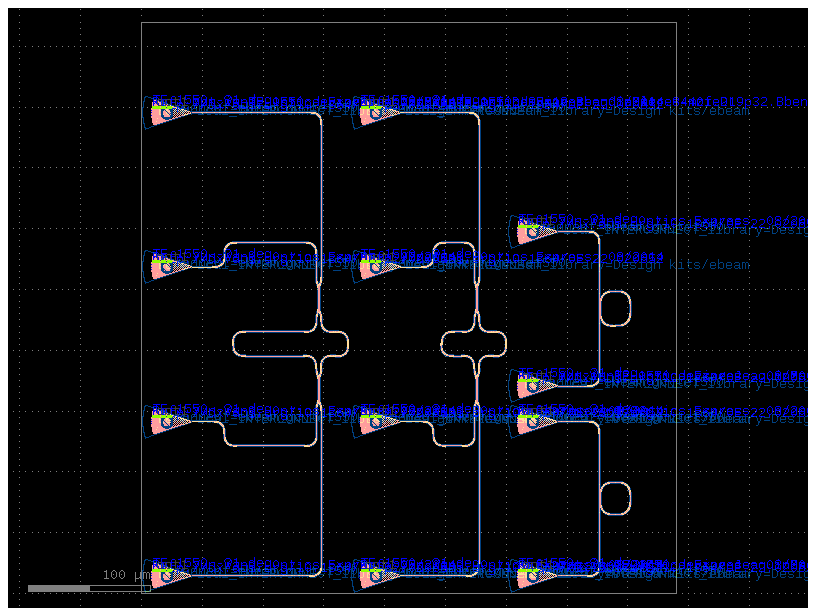

In [18]:
from functools import partial

import gdsfactory as gf

from ubcpdk.tech import LAYER

size = (440, 470)
add_gc = cells.add_fiber_array


@gf.cell
def EBeam_JoaquinMatres_1() -> gf.Component:
    """Add DBR cavities."""
    e = [add_gc(cells.straight())]
    e += [add_gc(cells.mzi(delta_length=dl)) for dl in [9.32, 93.19]]
    e += [
        add_gc(cells.ring_single(radius=12, gap=gap, length_x=coupling_length))
        for gap in [0.2]
        for coupling_length in [2.5, 4.5, 6.5]
    ]

    c = gf.Component()
    _ = c << gf.pack(e, max_size=size, spacing=2)[0]
    _ = c << gf.components.rectangle(size=size, layer=LAYER.FLOORPLAN)
    return c


c = EBeam_JoaquinMatres_1()
c.show()  # show in klayout
c.plot()  # plot in notebook

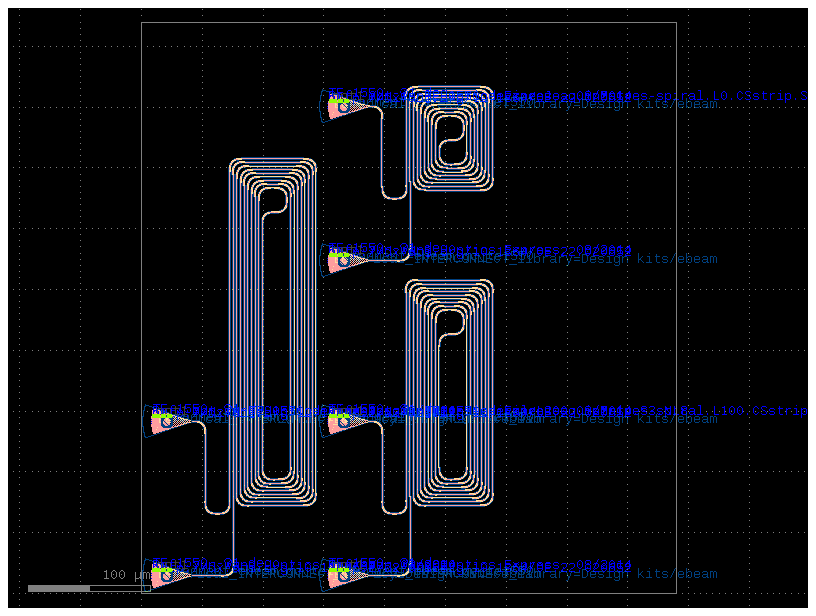

In [19]:
def EBeam_JoaquinMatres_2() -> gf.Component:
    """spirals for extracting straight waveguide loss"""

    e = [
        cells.add_fiber_array(component=cells.spiral(n_loops=8, length=length))
        for length in [0, 100, 200]
    ]

    c = gf.Component()
    _ = c << gf.pack(e, max_size=size, spacing=2)[0]
    _ = c << gf.components.rectangle(size=size, layer=LAYER.FLOORPLAN)
    return c


c = EBeam_JoaquinMatres_2()
c.show()  # show in klayout
c.plot()  # plot in notebook

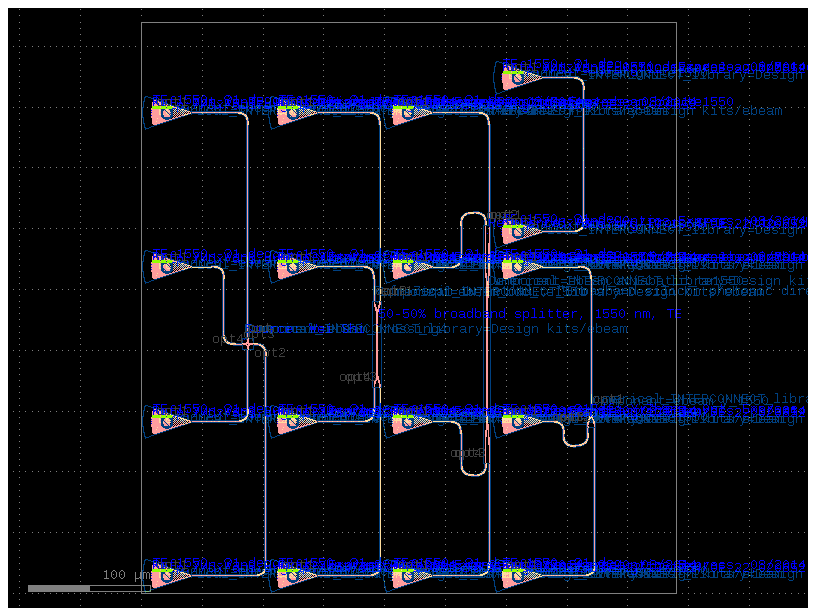

In [20]:
def EBeam_JoaquinMatres_3() -> gf.Component:
    """Contains mirror cavities and structures inside a resonator."""
    e = []
    e += [add_gc(cells.ebeam_crossing4())]
    e += [add_gc(cells.ebeam_adiabatic_te1550())]
    e += [add_gc(cells.ebeam_bdc_te1550())]
    e += [add_gc(cells.ebeam_y_1550())]
    e += [add_gc(cells.straight(), component_name=f"straight_{i}") for i in range(2)]
    c = gf.Component()
    _ = c << gf.pack(e, max_size=size, spacing=2)[0]
    _ = c << gf.components.rectangle(size=size, layer=LAYER.FLOORPLAN)
    return c


c = EBeam_JoaquinMatres_3()
c.show()  # show in klayout
c.plot()  # plot in notebook

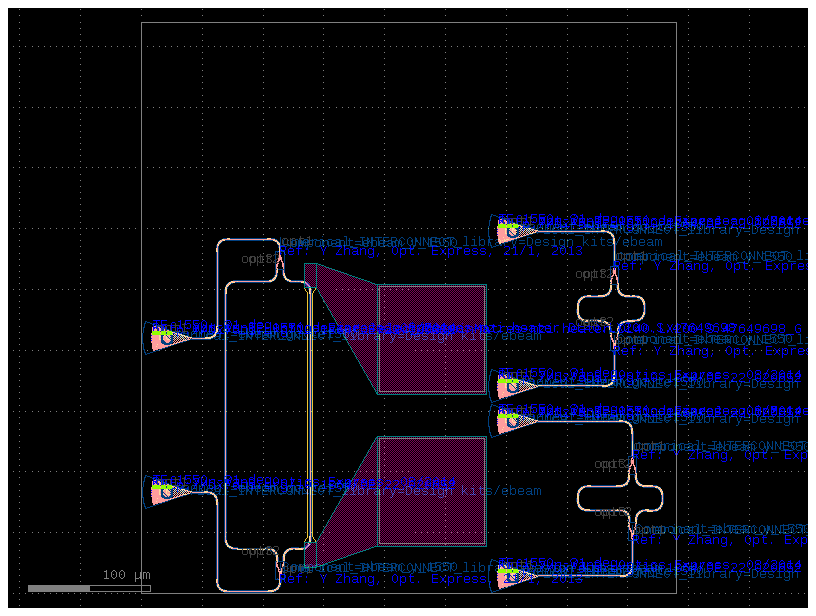

In [21]:
def EBeam_JoaquinMatres_4() -> gf.Component:
    """MZI interferometers."""
    mzi = partial(gf.components.mzi, splitter=cells.ebeam_y_1550)
    mzis = [mzi(delta_length=delta_length) for delta_length in [10, 40]]
    mzis_gc = [cells.add_fiber_array(mzi, fanout_length=5) for mzi in mzis]

    mzis = [cells.mzi_heater(delta_length=delta_length) for delta_length in [40]]
    mzis_heater_gc = [cells.add_fiber_array_pads_rf(mzi, orientation=90) for mzi in mzis]

    e = mzis_gc + mzis_heater_gc
    c = gf.Component()
    _ = c << gf.pack(e, max_size=size, spacing=2)[0]
    _ = c << gf.components.rectangle(size=size, layer=LAYER.FLOORPLAN)
    return c


c = EBeam_JoaquinMatres_4()
c.show()  # show in klayout
c.plot()  # plot in notebook

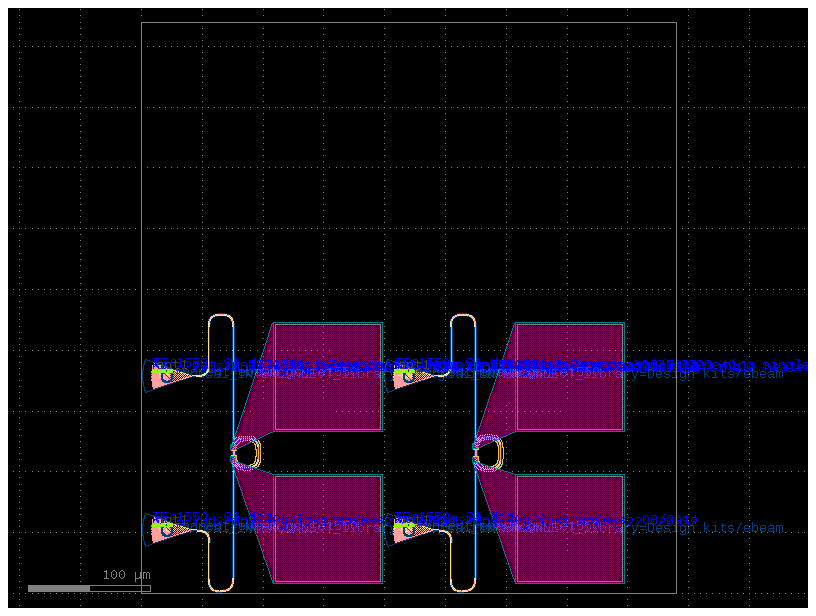

In [22]:
def EBeam_JoaquinMatres_5() -> gf.Component:
    """Ring resonators."""

    rings = []
    for length_x in [4, 6]:
        ring = cells.ring_single_heater(length_x=length_x)
        ring_gc = cells.add_fiber_array_pads_rf(ring, pad_yspacing=10)
        rings.append(ring_gc)

    c = gf.Component()
    _ = c << gf.pack(rings, max_size=size, spacing=2)[0]
    _ = c << gf.components.rectangle(size=size, layer=LAYER.FLOORPLAN)
    return c


c = EBeam_JoaquinMatres_5()
c.show()  # show in klayout
c.plot()  # plot in notebook